In [45]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import cv2
import easyocr
import pytesseract
from PIL import Image
import pandas as pd

In [10]:
invoice2  = imread("data/images/A 297364297/page-1.jpg")

In [11]:
invoice1  = Image.open("data/images/A 297364297/page-1.jpg").convert("L")

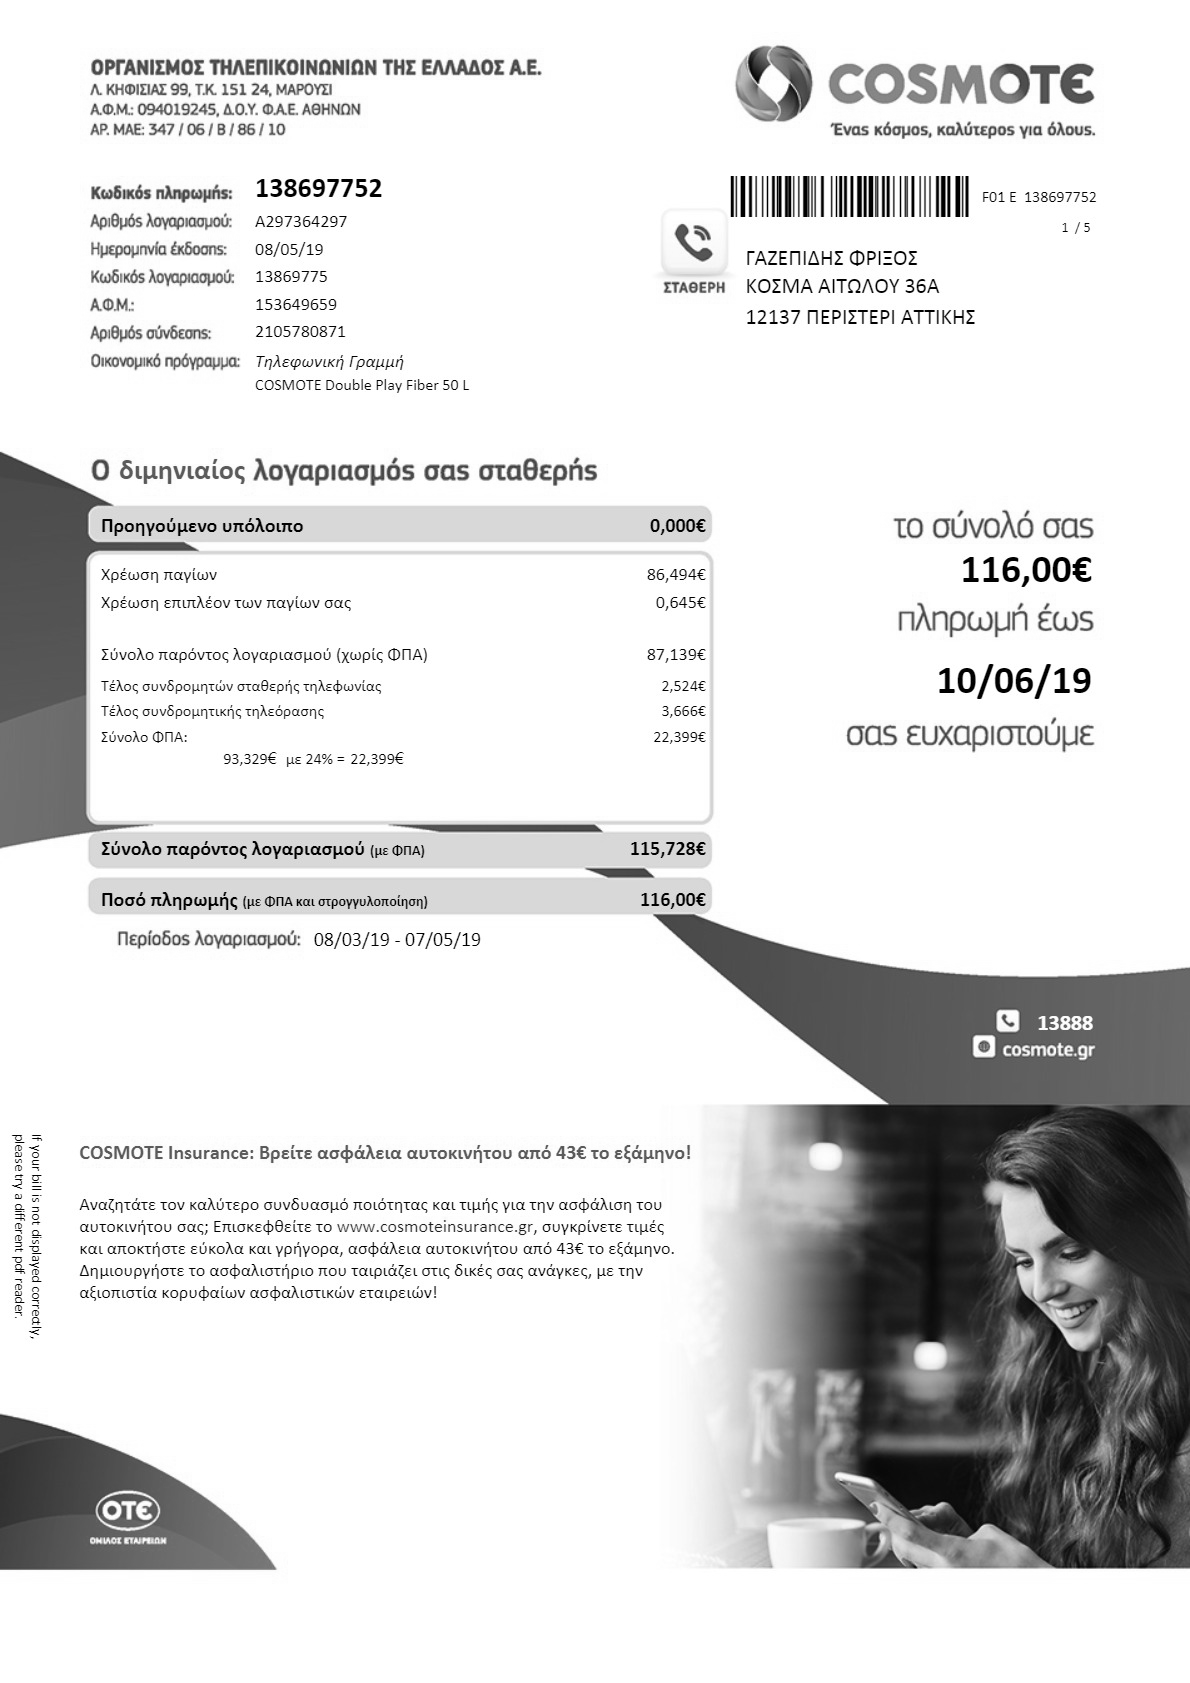

In [12]:
invoice1

In [13]:
invoice2

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [14]:
np.asarray(invoice1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

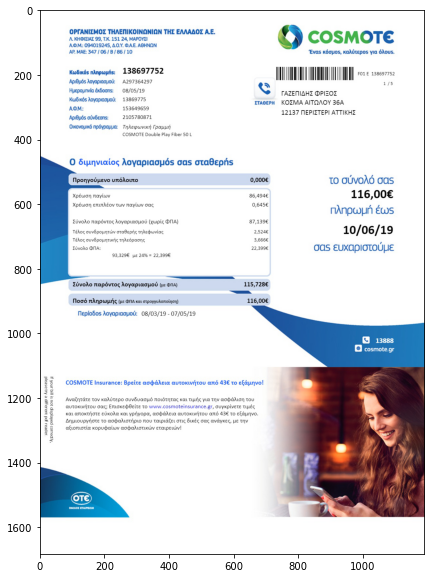

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(np.asarray(invoice2), cmap='gray')
None

# Inverted Image

In [16]:
inverted_invoice  = cv2.bitwise_not(np.asarray(invoice1))

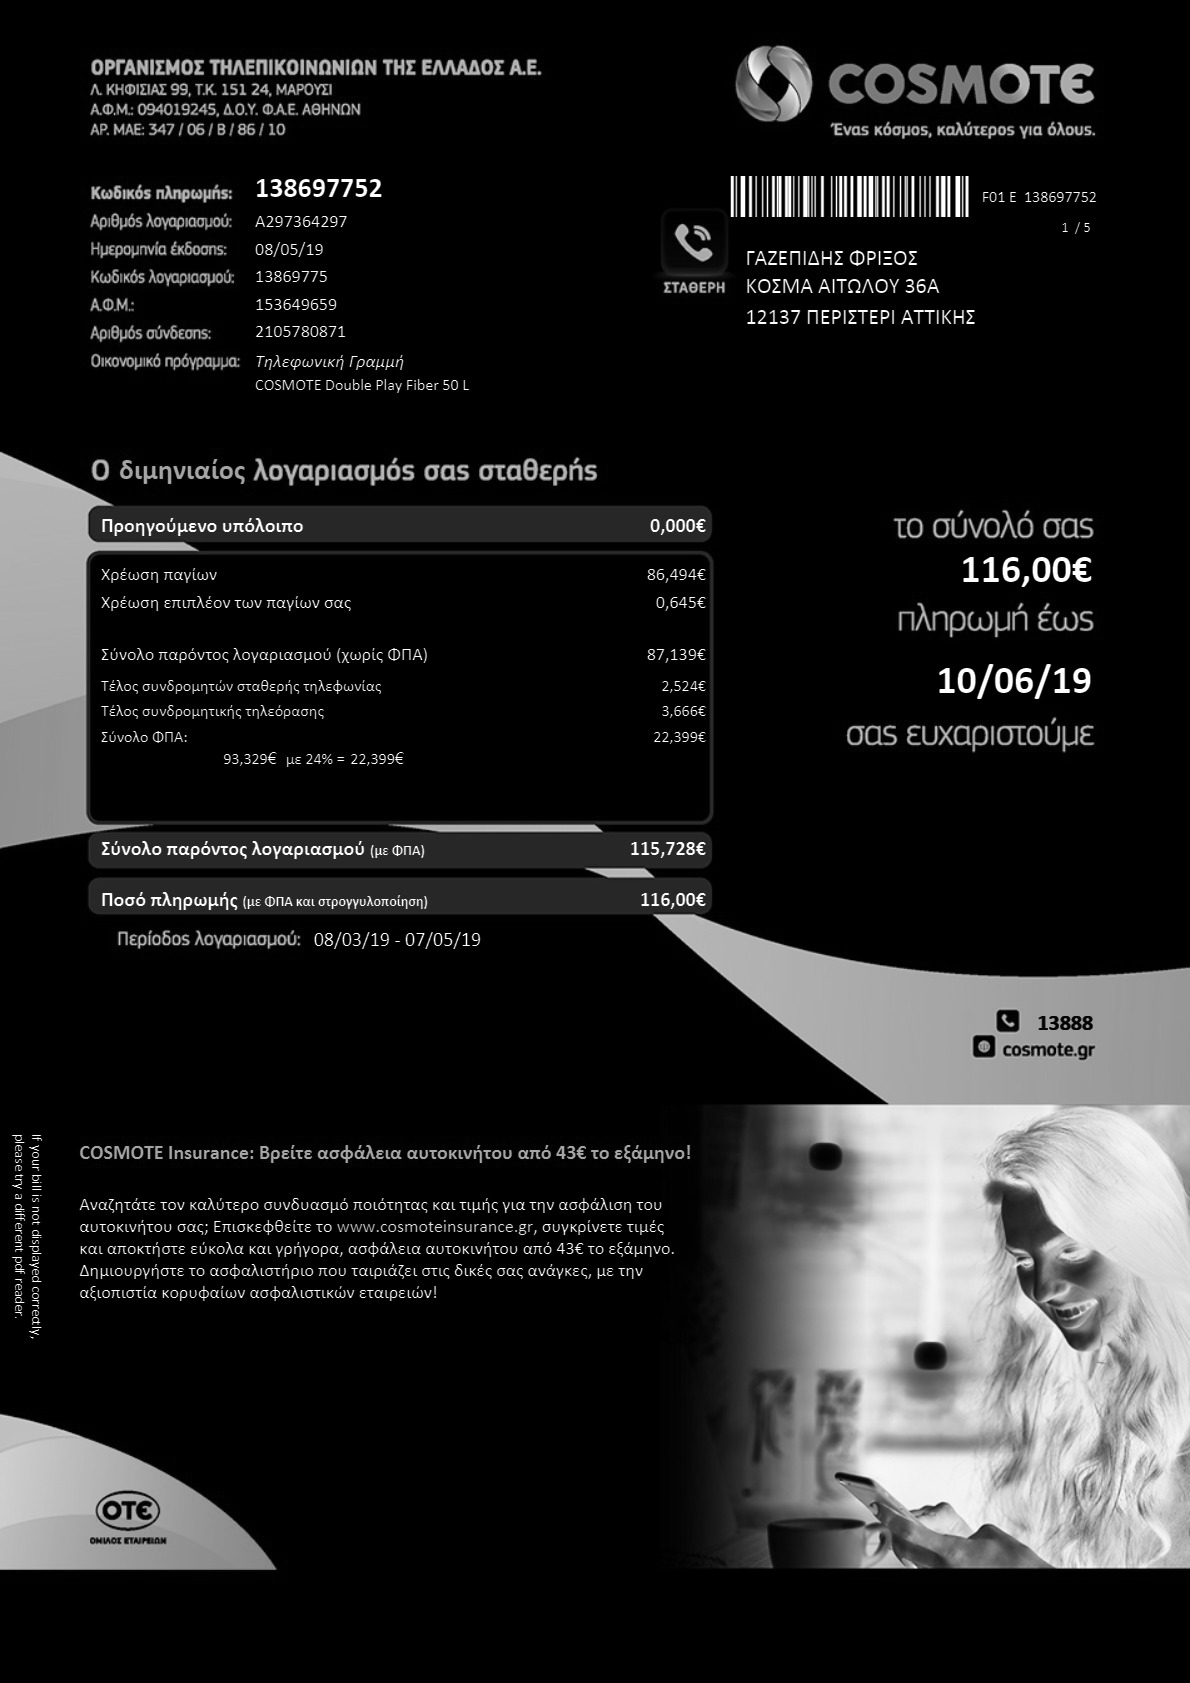

In [17]:
Image.fromarray(inverted_invoice)

In [18]:
inverted_invoice  = cv2.bitwise_not(invoice2)

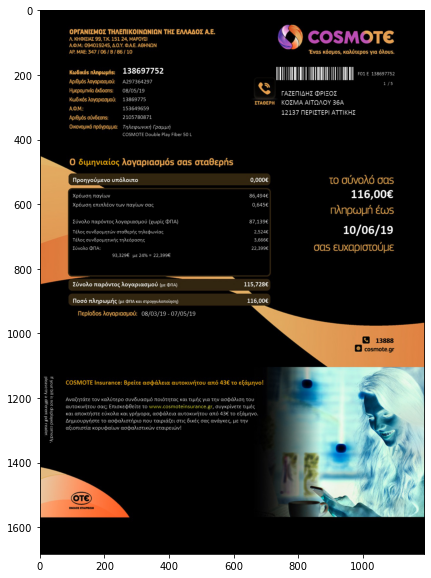

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(inverted_invoice, cmap='gray')
None

# Binarization

In [20]:
def greyscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [26]:
grey_invoice = greyscale(invoice2)

In [27]:
grey_invoice

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [28]:
thresh, im_bw = cv2.threshold(grey_invoice, 200, 230, cv2.THRESH_BINARY)

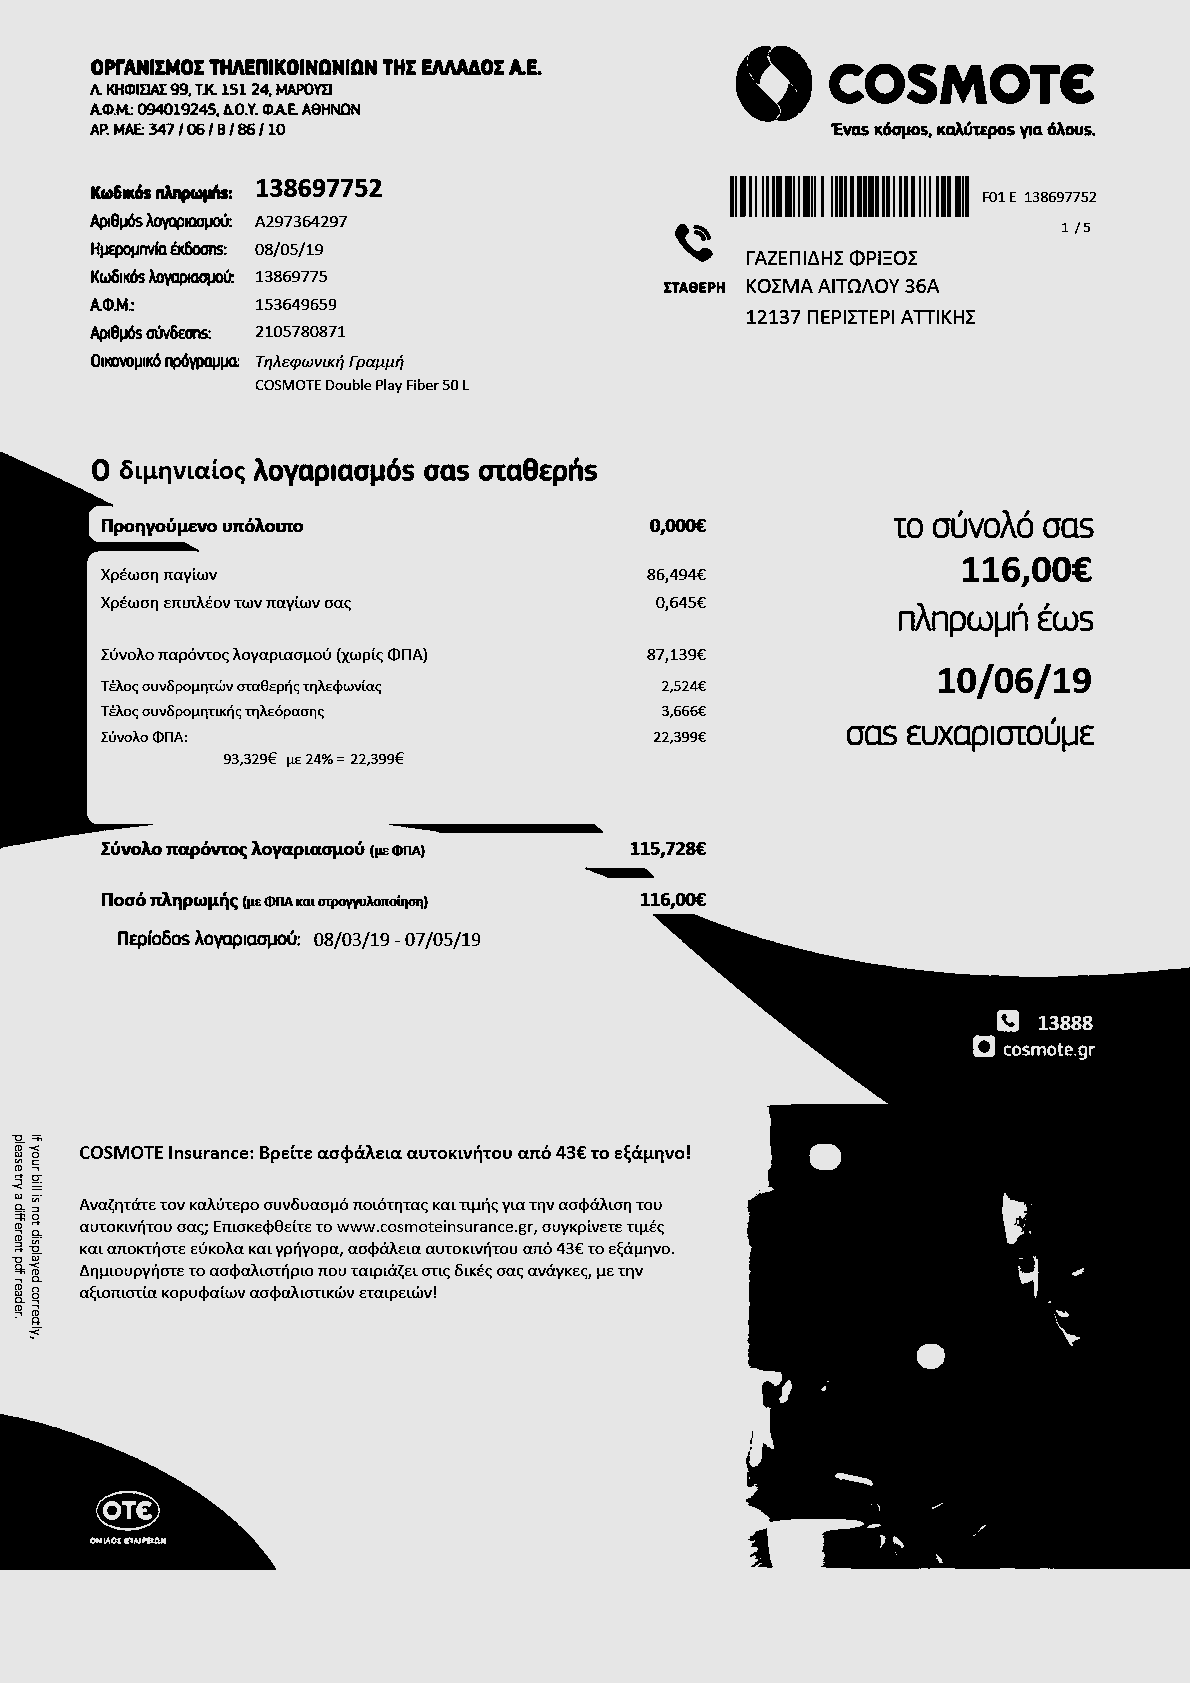

In [29]:
Image.fromarray(im_bw)

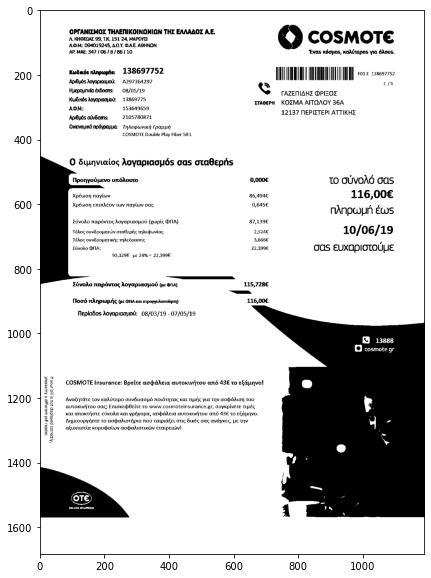

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(im_bw, cmap="gray")
None

# Noise Removal

In [31]:
def noise_removal(image):
    kernel = np.ones((1,1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1,1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return image

In [32]:
no_noise = noise_removal(im_bw)

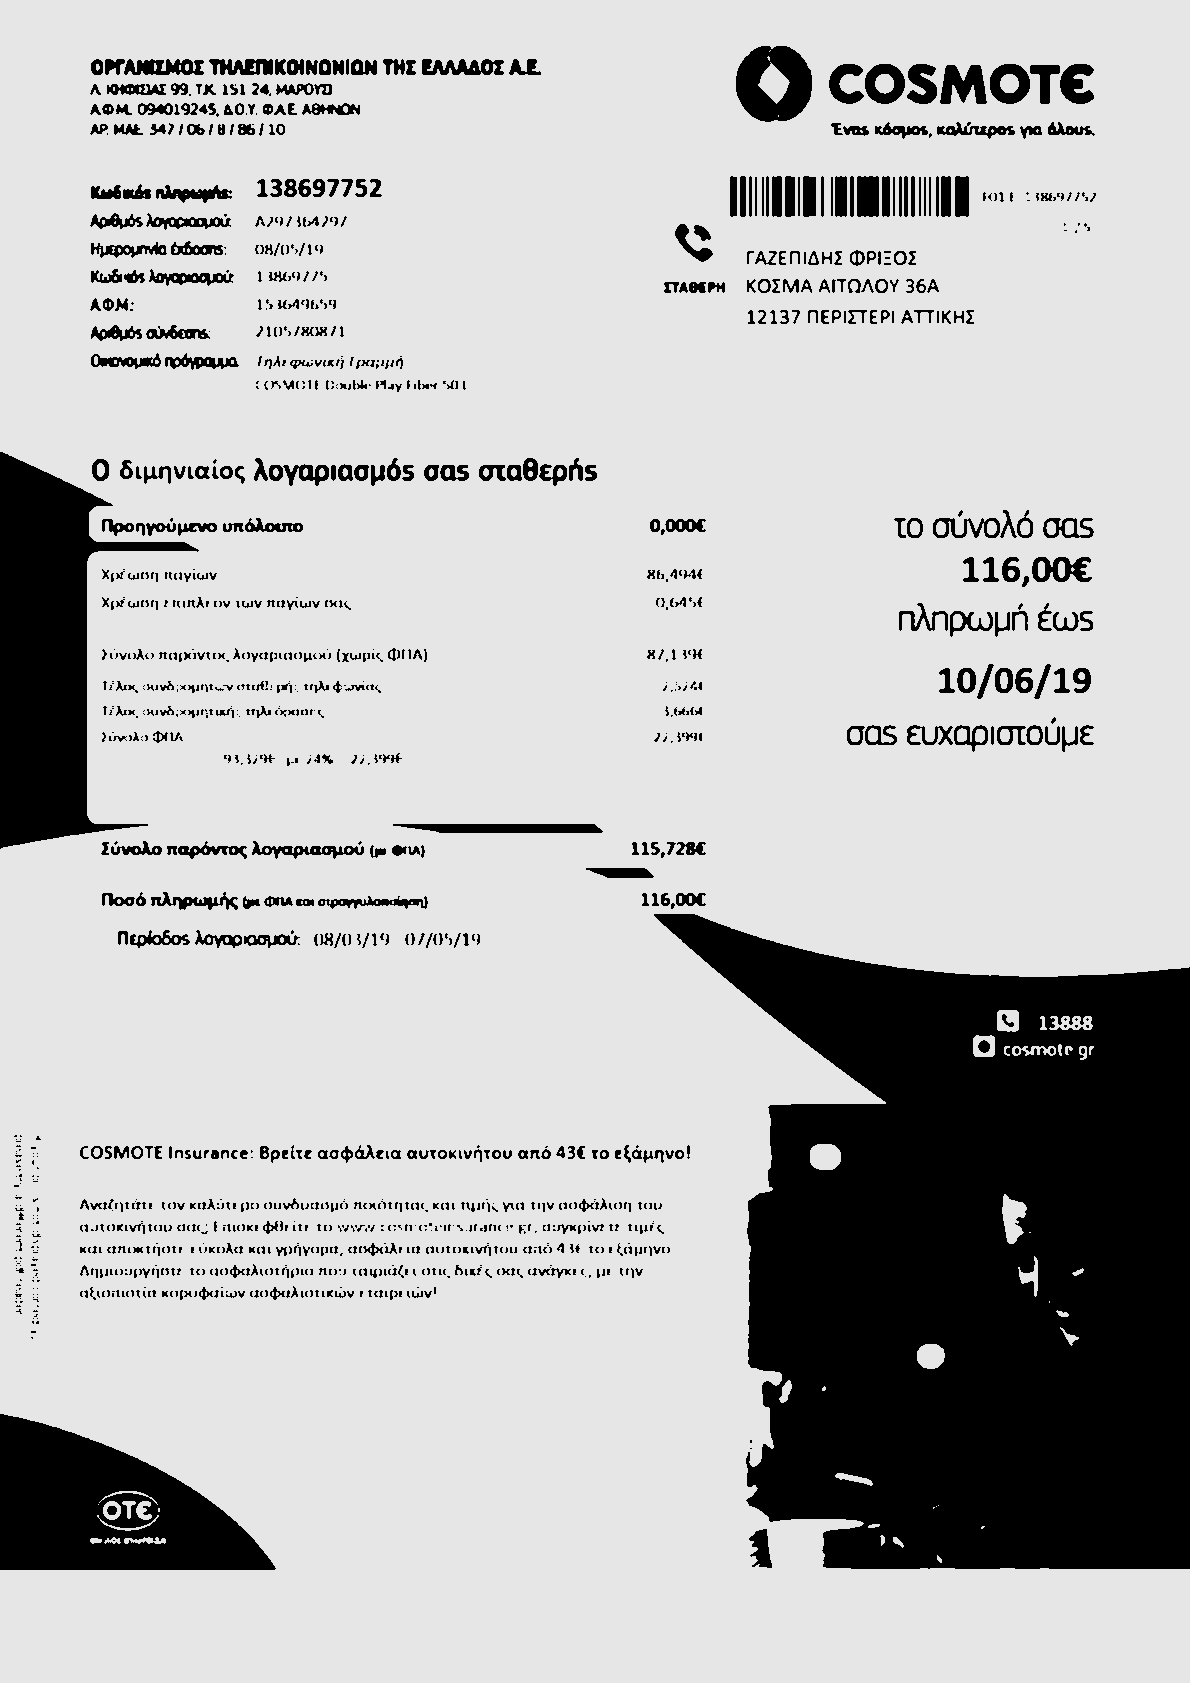

In [33]:
Image.fromarray(no_noise) # Not good result no need for de noising

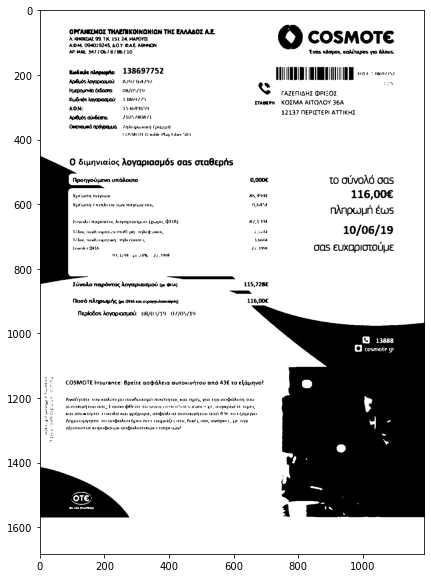

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(no_noise, cmap="gray")
None

# Rotation / Deskewing

In [5]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [6]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [213]:
fixed_invoice = deskew(np.asarray(invoice2))

52


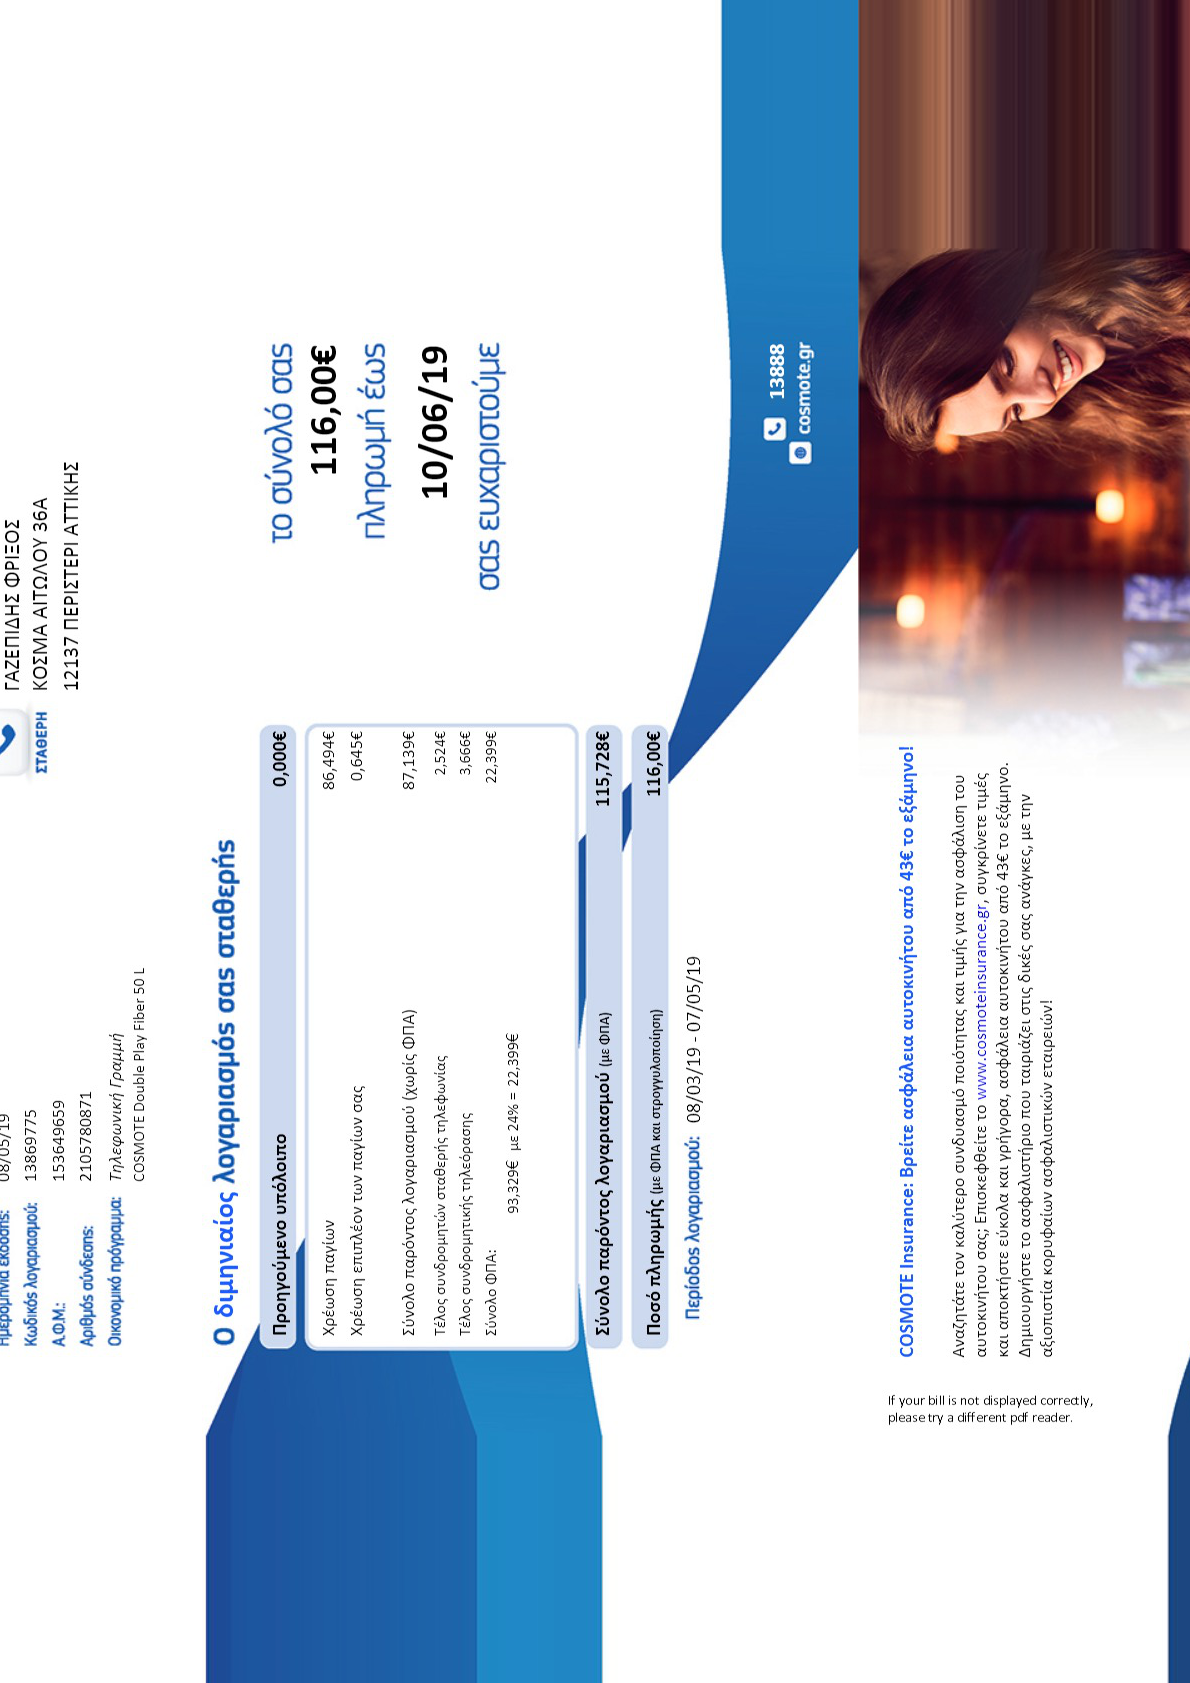

In [214]:
Image.fromarray(fixed_invoice) # the photo was not rotated that's it is not working well

In [20]:
invoice.shape # three color channels RGB 

(1683, 1190, 3)

In [21]:
invoice = invoice/255.0

In [22]:
invoice

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

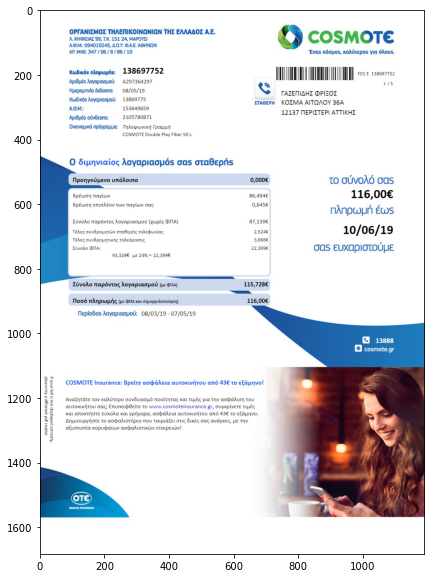

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(invoice)
None

In [36]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(im_bw, lang='eng', config=custom_config)

In [37]:
text

'OPI\'MIIIMOE THAEIIIKDINDNIIIN THE EAMAOZ LE.\n49.9949999949999949999 COSMOTC\nAOM; 094019245101. ms. AeHNDN\nAnmesulos/alsslm ‘Evusxéauosmnlﬁupusvmﬂous.\n““W“ 138697752 |||||||||||||||||||||||||||||||||||||||| w”\nmews Aammuox‘x 11297354297 i 1 ,5\nHmmms 03/05/19 ’V I\'AZEI\'IIAHZ (DPIEOZ\n“WWW ““9775 mam KOZMA AITnon 36A\nAWN: 153649659\n12137 I\'IEPIFI\'EPI A‘I\'I\'IKHZ\nmews mm 2 105780871\nOlmvoulnb WNW Trmwmvmq\' rpuuuri\nCOSMOTE Double Play Fiber SD L\nO 5LanLai0§ Aoyapuaopés oas maespl‘ls\n4 ,\nﬂpuqvnupzvo unohm 0,0006 \'[0 ouvvo gas\n994949 116,00€\nXpémun snmAs‘ov va nnvimv um; 0,6456 I 9\nW [3an $035\n2091vo nupdvmg Aoyapmopoo (xmpic (DI\'IA) 87,1396\nTang ouvﬁpopnm\'w omﬂzpr\'lq Inktbmviaq 2,52“: 10/06/ 1 9\nTang ouvﬁpopnukr\'lq mképuun; 3,55% I\n2.3on @nA: 12,359€ COS EUXODIOIOULJE\n93,325€ pz 24% : 12,359E\n—\nEl\'woln nupt\'wmg lovapuwpm\'r (p2 om. 115,7285\n_\nI\'lom\') "qumw\'lc ﬂquWﬁ-m) 116,006\nneplaﬁos onupluuuoﬁ: 08/03/19 9 07/05/19\n13333\nO cosmotegr\n$5; cosmon

In [55]:
reader = easyocr.Reader(['en'])
lst = reader.readtext('data/images/A 297364297/page-1.jpg')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [98]:
lst[39]

([[101, 645], [431, 645], [431, 666], [101, 666]],
 'Zuvolo napovtog AovaplaGuou (xwpic OnA)',
 0.6524381598997315)

In [2]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"

In [46]:
img = cv2.imread('data/images/A 297364297/page-1.jpg')
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(img, lang='eng', config=custom_config)

In [47]:
text

'OPI\'ANILMOI THAEI\'IIKDINDNION TH: EAMAOI AE.\nA. KHOIM 99. TX. 15) 24, mm CosMoTe\nA0 M. 094019245, A0]. OLE. ASHNON\nAlamasulosla/asuo ‘Evnsxﬁauosmﬂﬁupnsyméxous.\n”“W= 138597752 |\\|||H|||||l|||H|||||I|||H|||||||||\\|\nmums Mmmum’r. A297354297 ﬂ 1 / 5\nWM“ W, 03/05/19 ‘0 I\'AZEI\'IIAHZ LDPIEO:\nWWW ”“9775 mam KOZMA Aronv 36A\nLON: 153649659\n12137 I\'IEPIZTEPI A\'I\'I\'IKHZ\nmemsm 2105780871\nOlmvwmé Wm TnAwwvm} rpwwj\nCOSMOTE DoublE P‘av Fiber 50 L\n0 alpnvmioq Aoyuplaaués ans otueepl‘ls\nUponyoﬁpevo unaAomo o,oooe \'[0 00vo)\\(j gas\nXpémcn naviwv 86,494€ 1 16\' oo€\nXpéwun enmxéov mv nuviwv Cm: 0,6456 , ,\nnAnpwun ems\n:ovoxo napév’mc onupxaopob (xwpi: (DI\'IA) 37,139e\nmm; auvspowmv maezgnqxnhsttmviu; 2,524: 10/ 06/ 19\nTz\'Aug auvépopnnkhq mku‘puonq 3,665: I\n:ovoxo (DI\'IA: 22,399€ COS EUXGpIOIOUHE\n93,329E ME 24% : 21,399€\n—\nzovoAa napéqu Mvuplrwpm\') [mom] 115,7zse\n_\nI\'loaé anwuﬁc (pi (DHAImoIpwvuAnnninurl) 116,00€\nnzpioﬁns onupluapod: 08/03/19 , 07/05/19\n13888\nO co

In [12]:
from string import punctuation

In [44]:
text = "".join([i for i in text if i not in punctuation]).replace('\n', "").replace('\u2026', "")

In [45]:
text.lower()

'0ρλνι0σ πικ0ινπνων της ο αελ  99 τκ 151 24  ςοεμοτεαφ μ 9245 δο φλε αθηνωναρεμ7οεωω ένπ5ι5κµ5γάλω5  ηηαμ  αζ97364197  1  5  η19  ιαζεπιδης ωριξος 13869775 π κοσμα ατωλου 36αλθμξ 15364965912137 περιστερ απκησψθ 21057808710ιµικ6 να τηλεφωνική γραµμήζοξμοτε βο«όε πεν πβθγ 50 ο διµηνιαίος λογαριασµός σας σταθερήςπροηγούμενο υπόλοιπο οοοο€ το σύνολό σαςχρέωση παγίων 86494€ 1 16 00€χρέωση επιπλέον ν παγίων σας ο645€  πληρωμι1 εωςσύνολο παρόντος λογαριασµού  ωπαμ 8713τέλος συνδρομητών αθερηςιηλεφς 151 100619τέλος συνδρομητικής τηλεόρασης 366€€ σύνολο ωπα 2239 005 ευχσρσουμε93319€ με 24  21399€σύνολα παρόντας λογαριασμού ο 1157ιε€ποσό πληρωµής µε ω 11600€περίοδος λογαριασµού 080319 7 070519138886 οςπιοιςτξξ εοεινιοτε ι βρείτε ασφάλεια αυτοκινήτου  43€  εξάμηνο ξ ξξ ξ αναζητάτε τον καλύτερο συνδυασμό πος  τιμής  την ασφάλιση πξ ξ αυτοκινήτου σας επισκεφθείτε  ψωννωεσωίπ5ωεμεςη συγκρε τιµέςξ € και πποκήστξ εύκολα και νρήγορα ασφάλεια αυτοκινήτου  43€  εξάμηνο  δηµιουργήστε  ασφαλιστήρια  ταιριά

'…'

# ME

In [122]:
me = Image.open("data\me\IMG_20211118_171323.jpg")

In [123]:
type(me)

PIL.JpegImagePlugin.JpegImageFile

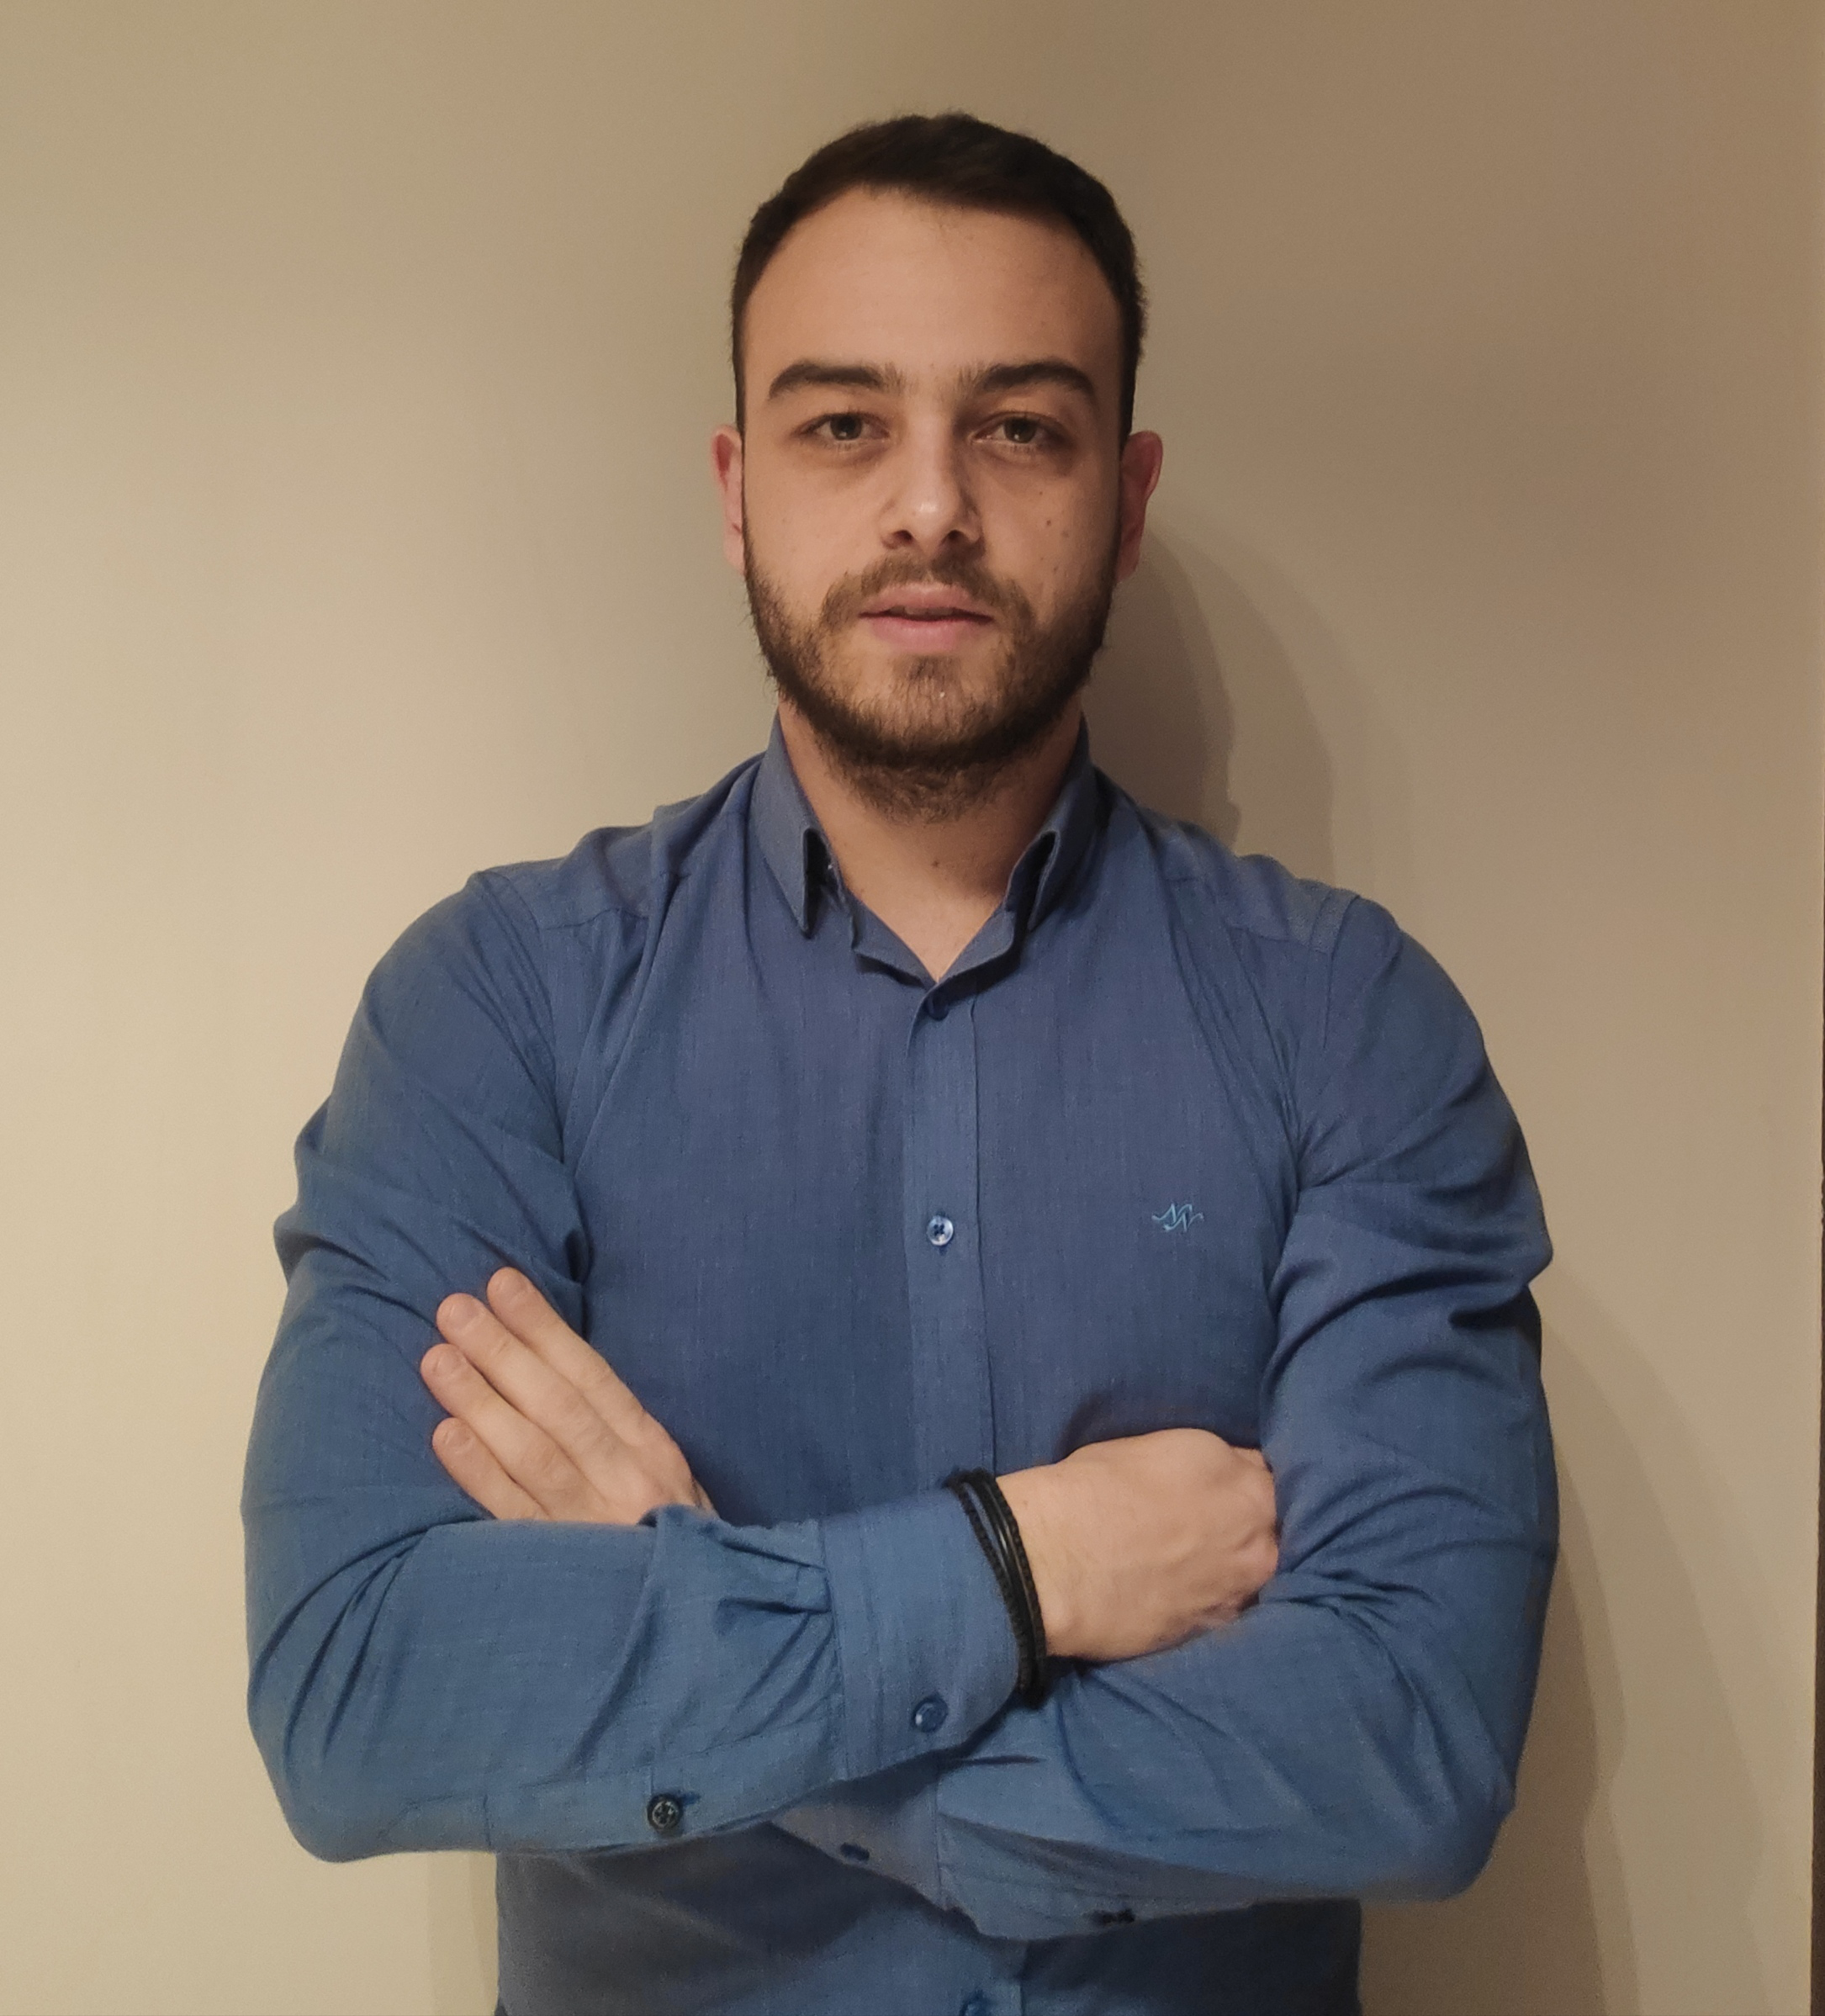

In [124]:
me

In [125]:
me_array_scaled = np.asarray(me)/255.0

In [126]:
me_array_scaled

array([[[0.68627451, 0.61176471, 0.48627451],
        [0.68627451, 0.61176471, 0.48627451],
        [0.69019608, 0.61568627, 0.49019608],
        ...,
        [0.59215686, 0.49411765, 0.37647059],
        [0.59215686, 0.49411765, 0.37647059],
        [0.59215686, 0.49411765, 0.37647059]],

       [[0.69411765, 0.61960784, 0.49411765],
        [0.69411765, 0.61960784, 0.49411765],
        [0.69411765, 0.61960784, 0.49411765],
        ...,
        [0.6       , 0.50196078, 0.38431373],
        [0.59607843, 0.49803922, 0.38039216],
        [0.59607843, 0.49803922, 0.38039216]],

       [[0.69411765, 0.61960784, 0.49411765],
        [0.69019608, 0.61568627, 0.49019608],
        [0.69019608, 0.61568627, 0.49019608],
        ...,
        [0.60392157, 0.50588235, 0.38823529],
        [0.60784314, 0.50980392, 0.39215686],
        [0.60784314, 0.50980392, 0.39215686]],

       ...,

       [[0.78431373, 0.7254902 , 0.60392157],
        [0.78431373, 0.7254902 , 0.60392157],
        [0.78039216, 0

In [127]:
me_array_scaled.shape

(2397, 2170, 3)

In [128]:
X = me_array_scaled.reshape(-1,3)

In [129]:
X.shape

(5201490, 3)

# Segmentation

In [131]:
from sklearn.cluster import KMeans

In [169]:
km =KMeans(n_clusters=2)
km.fit(X)

KMeans(n_clusters=2)

In [170]:
km.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [171]:
km.labels_.shape

(5201490,)

In [281]:
img_seg_centers = km.cluster_centers_

In [282]:
img_seg_centers

array([[0.68718776, 0.59704974, 0.49366021],
       [0.26643372, 0.28832322, 0.3477821 ]])

In [283]:
img_seg = img_seg_centers[km.labels_]

In [284]:
img_seg

array([[0.68718776, 0.59704974, 0.49366021],
       [0.68718776, 0.59704974, 0.49366021],
       [0.68718776, 0.59704974, 0.49366021],
       ...,
       [0.26643372, 0.28832322, 0.3477821 ],
       [0.26643372, 0.28832322, 0.3477821 ],
       [0.26643372, 0.28832322, 0.3477821 ]])

In [268]:
img_seg.shape

(5201490, 3)

In [269]:
km.labels_.reshape(img_seg.shape[0], 1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [270]:
img_seg = np.append(img_seg, km.labels_.reshape(img_seg.shape[0], 1), axis=1)

In [271]:
img_seg

array([[0.68718776, 0.59704974, 0.49366021, 0.        ],
       [0.68718776, 0.59704974, 0.49366021, 0.        ],
       [0.68718776, 0.59704974, 0.49366021, 0.        ],
       ...,
       [0.26643372, 0.28832322, 0.3477821 , 1.        ],
       [0.26643372, 0.28832322, 0.3477821 , 1.        ],
       [0.26643372, 0.28832322, 0.3477821 , 1.        ]])

In [272]:
img_seg[0][3]

0.0

In [273]:
for row in img_seg:
    if row[3] == 0:
        row[0] = 0
        row[1] = 0
        row[2] = 0

In [274]:
img_seg

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.26643372, 0.28832322, 0.3477821 , 1.        ],
       [0.26643372, 0.28832322, 0.3477821 , 1.        ],
       [0.26643372, 0.28832322, 0.3477821 , 1.        ]])

In [275]:
img_seg[:,:-1]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.26643372, 0.28832322, 0.3477821 ],
       [0.26643372, 0.28832322, 0.3477821 ],
       [0.26643372, 0.28832322, 0.3477821 ]])

In [276]:
img_seg = img_seg[:,:-1].reshape(me_array_scaled.shape)

In [285]:
img_seg = img_seg.reshape(me_array_scaled.shape)

In [287]:
img_seg

array([[[0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        ...,
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021]],

       [[0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        ...,
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021]],

       [[0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        ...,
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021]],

       ...,

       [[0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0.59704974, 0.49366021],
        [0.68718776, 0

In [278]:
img_seg.shape

(2397, 2170, 3)

In [279]:
img_seg[0][0]

array([0., 0., 0.])

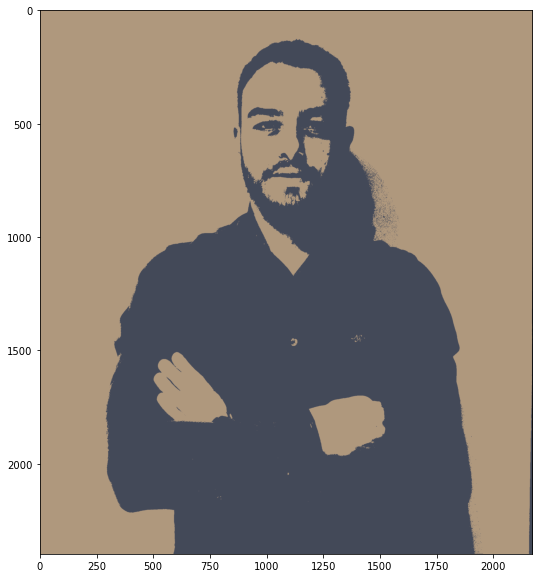

In [288]:
plt.figure(figsize=(20,10))
plt.imshow(img_seg)
None